
ratio=  0.00 %

Finding optimal x_wec & x_pen while holding x_env as parameter:


                capture_width   pen_diameter   pen_height     stock_density 
temp           |  0           |  0           |  0           |  0           |
O2_in          |  0           |  0           |  0           |  0           |
wave_height    | -1.010750    |  0.215916    |  0.557418    |  0           |
wave_period    | -0.505336    |  0.107984    |  0.278697    |  0           |

ratio=  0.00 %

Finding optimal x_env while holding x_wec & x_pen as parameter:


                temp           O2_in          wave_height    wave_period  
capture_width  |  0           |  0           | -0.496150    | -0.007706    |
pen_diameter   |  0           |  0           |  0.991960    |  0.016099    |
pen_height     |  0           |  0           |  0.496122    |  0.007762    |
stock_density  |  0           |  0           |  0.496122    |  0.007762    |


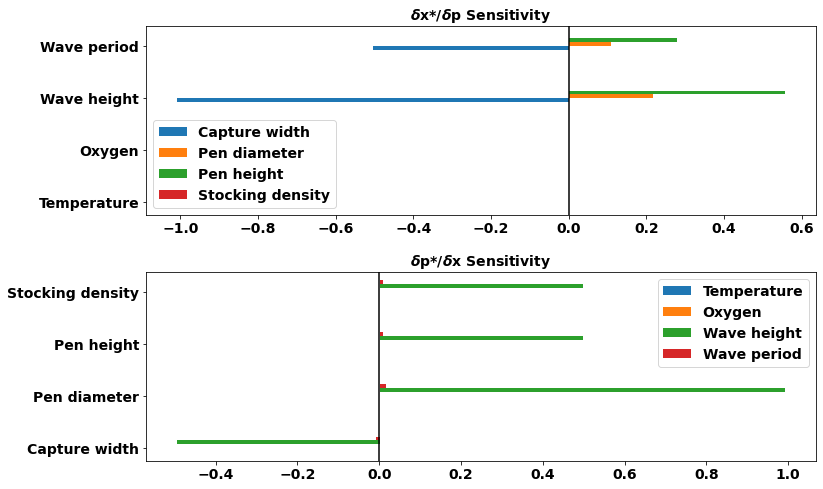

In [4]:
import numpy as np
import math
import modules
import optimization
from scipy.optimize import minimize
import matplotlib.pyplot as plt

max_iter = 2000
fs = 14  # font size

def plot_sensitivity(results, x_label, y_label, Title, ax):
    dim = len(results[0])
    w = 0.3
    dimw = w / dim    
    
    x_label = list(map(lambda st: str.replace(st, 'O2_in', 'Oxygen'), x_label))
    y_label = list(map(lambda st: str.replace(st, 'O2_in', 'Oxygen'), y_label))
    x_label = list(map(lambda st: str.replace(st, 'stock', 'Stocking'), x_label))
    y_label = list(map(lambda st: str.replace(st, 'stock', 'Stocking'), y_label))
    x_label = list(map(lambda st: str.replace(st, 'temp', 'Temperature'), x_label))
    y_label = list(map(lambda st: str.replace(st, 'temp', 'Temperature'), y_label))
    x_label = list(map(lambda st: str.replace(st, '_', ' '), x_label))
    y_label = list(map(lambda st: str.replace(st, '_', ' '), y_label))
    x_label = [label.capitalize() for label in x_label]
    y_label = [label.capitalize() for label in y_label]

    x = np.arange(len(results))
    
    for i in range(len(results[0])):
        y = [d[i] for d in results]
        b = ax.barh(x + i * dimw, y,
                    dimw, left = 0.001)
    ax.set_yticks(x + dimw / 2)
    ax.set_yticklabels(y_label)    
    ax.legend(x_label) #, loc='upper left' # title="title"
    ax.set_title(Title, fontsize = fs, fontweight = 'bold')

    ax.axvline(0, color="k")
    
    Title = Title.replace("/", "_")

    font = {'weight': 'bold',
            'size': fs}    
    plt.rc('font', **font)

def ratio_finder(f):
    
    # Perturbation Size Δx Choice based on Gill et. al. 1983
    eps = 1e-8
    delta_X = math.sqrt(eps / abs(f))
    
    print('\nratio= ', "{:1.2f}".format(delta_X*100), '%')
    ratios = [1-delta_X/2, 1, 1+delta_X/2]
    return ratios

def sensitivity_sweep(v1_name, v2_name, all_vars):
    # v1: variable being swept, held constant for each optimization
    # v2: variable being optimized

    param_list, param_val, param_unit, param_bnds, param_label = optimization.default_value(v1_name)
    res_opt, op_obj = optimization.run_optimization(v2_name, [], v1_name, param_val, all_vars, max_iter)
    v1_ratios = ratio_finder(res_opt.fun)
    x_star = res_opt.x

    v1_list, v1_nom, v1_unit, v1_bnds, v1_label = optimization.default_value(v1_name)
    v2_list, v2_nom, v2_unit, v2_bnds, v2_label = optimization.default_value(v2_name)
    
    num_v1 = len(v1_list)
    num_v2 = len(v2_list)
    num_ratios = len(v1_ratios)
    
    v2_star = np.zeros(shape=(num_v1,num_ratios,num_v2))
    dv2_star_dv1 = np.zeros(shape=(num_v1,num_v2))

    desc = '\nFinding optimal '+ v2_label + ' while holding '+ v1_label + ' as parameter:'
    print(desc)
    
    for i in range(num_v1):
        for j in range(num_ratios):
            v1 = dict. copy(v1_nom)
            v1[v1_list[i]] = v1_nom[v1_list[i]] * v1_ratios[j]
            res_opt, op_obj = optimization.run_optimization(v2_name, x_star, v1_name, v1, all_vars, max_iter)
            if res_opt.success:
                v2_star[i,j,:] = res_opt['x']
            else:
                v2_star[i,j,:] = np.nan
                print('failing for:',v1)            

        idx_nom = v1_ratios.index(1)
        dv2_star = np.divide((v2_star[i,-1,:] - v2_star[i,0,:]), v2_star[i,idx_nom,:])
        dv2_star_dv1[i,:] = dv2_star / (v1_ratios[-1] - v1_ratios[0])    

    # print result in a table format
    print('\n')
    col_width = len(max(v2_list+v1_list, key=len)) + 1
    print(' '*col_width, end='')
    for i in range(num_v2):
        print(' ',v2_list[i], ' '*(col_width-len(v2_list[i])-2),end='')
    print('')
    for i in range(num_v1):
        print(v1_list[i], ' '*(col_width-len(v1_list[i])),end='|')
        for j in range(num_v2):
            if (dv2_star_dv1[i,j] == 0):
                print('  0', ' '*(col_width-4),end='|')
            elif np.isnan(dv2_star_dv1[i,j]):
                print("  \x1b[31mFailed\x1b[0m", ' '*(col_width-9),end='|')
            else:
                print("{:10.6f}".format(dv2_star_dv1[i,j]), ' '*(col_width-11),end='|')
        print('')
        
    return dv2_star_dv1, v2_list, v1_list


all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_env','p_wec','p_fish_salmon']

fig, ax = plt.subplots(2,1, figsize=(12, 8))

# sensitivity of optimal wec and pen design to environment/location
design_var = ['x_wec','x_pen']
parameter = ['x_env']
dx_wec_pen_star_dx_env, list_v2, list_v1 = sensitivity_sweep(parameter, design_var, all_vars)
title = '$\delta$x*/$\delta$p Sensitivity'
ax1 = plt.subplot(211)
plot_sensitivity(dx_wec_pen_star_dx_env, list_v2, list_v1, title, ax1)
#print('\n\ndx_wec_pen_star_dx_env=\n', dx_wec_pen_star_dx_env)
#print('\n*************************************************\n\n')


# sensitivity of optimal environment/location to wec and pen design
design_var = ['x_env']
parameter = ['x_wec','x_pen']
dx_env_star_dx_wec_pen, list_v2, list_v1 = sensitivity_sweep(parameter, design_var, all_vars)
title = '$\delta$p*/$\delta$x Sensitivity'
ax2 = plt.subplot(212)
plot_sensitivity(dx_env_star_dx_wec_pen, list_v2, list_v1, title, ax2)
#print('\n\ndx_env_star_dx_wec_pen=\n', dx_env_star_dx_wec_pen)
#print('\n*************************************************\n\n')

font = {'weight': 'bold',
            'size': fs}    
plt.rc('font', **font)
plt.subplots_adjust(hspace=0.3)

plt.savefig('results/Sensitivity.pdf' )
plt.savefig('results/Sensitivity.png', bbox_inches = "tight")
#plt.show()